# Class 6: Constructing a Network from Scraped Data

1. Come in. Sit down. Open Teams.
2. Make sure your notebook from last class is saved.
3. Open up the Jupyter Lab server.
4. Open up the Jupyter Lab terminal.
5. Activate Conda: `module load anaconda3/2022.05`
6. Activate the shared virtual environment: `source activate /courses/PHYS7332.202510/shared/phys7332-env/`
7. Run `python3 git_fixer2.py`
8. Github:
    - git status (figure out what files have changed)
    - git add ... (add the file that you changed, aka the `_MODIFIED` one(s))
    - git commit -m "your changes"
    - git push origin main
________

## Goals of today's class
1. Practice scraping news articles
2. Get comfortable with error handling
3. Build co-occurrence matrices & compare different kinds of co-occurrence matrices.

## The KarJenner Social Graph According to TMZ
Now, a fun exercise. We've used [`mediacloud.org`](https://www.mediacloud.org/documentation/search-api-guide) to obtain the URLs of all articles about the KarJenners (Kardashians & Jenners) from January 1st, 2024 until July 30, 2024. We'll load the article URLs and gradually construct a name co-occurrence network from a random subset of articles. Let's load the `.csv` of articles first.

In [1]:
import csv
with open('data/kardashian_jenner_urls_jan_1_2024_to_july_31_2024_mediacloud.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    urls = [line[-1] for line in reader][1:]
print(urls[0:5])

['https://www.tmz.com/2024/07/30/eminem-death-slim-shady-ai-interview-mgk-mother/', 'https://www.tmz.com/2024/07/29/khloe-kardashian-dinosaur-tatum-birthday-party-kris-kim/', 'https://www.tmz.com/2024/07/29/travis-barker-selling-post-crash-boarding-pass-personal-note/', 'https://www.tmz.com/2024/07/28/july-2024-hot-shots-dog-days-of-summer-will-have-you-panting/', 'https://www.tmz.com/2024/07/28/kanye-west-bianca-censori-tiny-shorts-take-north-west-deadpool/']


### Let's scrape an article! 
To make it fun, we'll each pick a random article to scrape and parse. We're going to use the `BeautifulSoup` python package to parse the HTML that we'll get via our `requests` module. 

In [7]:
from bs4 import BeautifulSoup
import random
import requests
my_url = random.choice(urls[0:-20]) # leave this; the last 20 URLs are corrupted for Learning Purposes
res = requests.get(my_url)
soup = BeautifulSoup(res.text)

Let's print out the soup. This will show us what the raw HTML looks like, and disincentivize us from ever writing our own HTML parsers! Note that there are a lot of Javascript scripts in there, denoted with `<script>` tags; these are often widgets or tracking features. 

In [3]:
soup

<!DOCTYPE html>
<html class="device-view-desktop viewer-country-us" data-device-view="desktop" data-env="prod" data-viewer-country="US" lang="es">
<!--
app_version=3.23.1
benchmark=102ms
etag=e83174e0c2f0452d67f0e6666cc1ffeb
timestamp=1727277528
timestamp_iso=2024-09-25T15:18:48.565986Z
screen=desktop-article
-->
<head>
<meta charset="utf-8"/>
<meta content="text/html; charset=utf-8" http-equiv="content-type"/>
<meta content="en" http-equiv="content-language"/>
<meta content="IE=Edge,chrome=1" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width,initial-scale=1,minimum-scale=0.25,maximum-scale=10" name="viewport"/>
<meta content="unsafe-url" name="referrer"/>
<title>Bad Bunny sube fotos en cueros desde su bañera, solo lo cubren un montón de burbujas</title>
<link href="/rss.xml" rel="alternate" title="Celebrity Gossip | Entertainment News | Celebrity News | TMZ.com" type="application/rss+xml"/>
<meta content="UUmtbUBf3djgPpCeLefe_PbFsOc6JGxfXmHzpjFLAEQ" name="google-site-ve

### Hunting for Meaning in the Soup
The neat part of BeautifulSoup is that we can search for specific tags in the HTML. In this case, we're hunting for `<p>` tags, which will contain the actual article text. Within the article text, if someone is an important celebrity or if they refer to another article, TMZ will link to the relevant TMZ page using a `<a>` tag. Let's hunt for these links: 

In [4]:
for text_line in soup.find_all('p'):
    a_tags = text_line.find_all('a')
    print(a_tags)

[<a href="https://www.tmz.com/people/bad-bunny/"><strong>Bad Bunny</strong></a>]
[]
[]
[]
[]
[]
[]
[]
[]
[<a class="js-track-link" data-context='{"section":"footer-subscribe","name":"privacy-policy"}' href="https://www.tmz.com/es/privacy" rel="noopener noreferrer" target="_blank">política de privacidad</a>, <a class="js-track-link" data-context='{"section":"footer-subscribe","name":"privacy-policy"}' href="https://www.tmz.com/es/terms" rel="noopener noreferrer" target="_blank">términos de uso</a>]


Let's say we just want the pages that correspond to people. These pages' URLs have the pattern `https://www.tmz.com/people/NAME`. We can use this pattern to filter out other pages, then use string manipulation to grab just the person's name:

In [5]:
people_in_article = []
for text_line in soup.find_all('p'):
    a_tags = text_line.find_all('a')
    for tag in a_tags:
        href = tag.get('href')
        if 'https://www.tmz.com/people/' in href:
            people_in_article.append(href.split('/')[-2])


In [6]:
people_in_article

['bad-bunny']

## A Minor Wrinkle
The full list of URLs contains about 20 URLs that I have edited and made invalid. We're going to practice dealing with these invalid URLs as we develop functionality to scrape TMZ articles and get a list of the people who appear in every article coming from a **valid** URL. Without further ado...

### Handling Errors
Sometimes, when you're scraping websites, a URL might not point to a valid web page, or something else unexpected might happen (the website might be down, for example). We don't want our code to give up entirely when it encounters one error, so we use *exception handling* techniques. The most common structure for handling exceptions in Python is the try/except block. Here's how it looks in its most basic form (as I recommend it):
```
try:
    do_something_that_might_fail()
except Exception as e:
    print(e)
    do_something_else_to_record_the_failure()
```
What we're doing here is the following. First, we attempt the instructions that are wrapped in the `try` block. If it raises an exception, which is any sort of error that breaks the code (maybe the website doesn't resolve, or you're trying to choose the 5th element of an empty list, or you're trying to add a string to a `None`...you get the idea), then this code will print the error and then follow a new set of instructions. 

We can build in multiple exceptions in a single try/except setup. Let's say we're worried about getting blank text from our web request *and* some other error with BeautifulSoup if we get some text back that isn't valid HTML. 
```
import requests
from bs4 import BeautifulSoup

try:
    txt = requests.get(url).text
    soup = BeautifulSoup(txt)
except requests.ConnectionError as e:
    print('connection error')
    print(e)
except Exception as e:
    print('other error')
    print(e)
    
```

### Logging Errors
Print statements are all well and good, but sometimes we want to log things a little more permanently. Enter the [`logging`](https://docs.python.org/3/library/logging.html) package. At a basic level, this lets you specify a file that you write all your log messages to (rather than printing them out to the terminal). The different levels of logging indicate what urgency a message should have in order to make it into your log file. The levels of urgency are (in increasing order) `[debug, info, warning, error]`. 
```
import logging

logger = logging.getLogger(__name__)

logging.basicConfig(filename='my_log.log', encoding='utf-8', level=logging.DEBUG)

logging.debug('is this thing on?')
logging.info('yep, i think it's on')
```

When you handle exceptions, this presents a great opportunity to write to a log and keep track of bad URLs or other errors. Then you can go back and figure out if there are any patterns you need to be concerned about.

### Being Considerate While Scraping
In order to be considerate scrapers, we do our best to not overload the website. This means we wait for 5 or so seconds, if not longer, between requests. We also don't scrape too much data; to start, I'll ask you to scrape 30 articles randomly chosen from our list of 330 URLs.  

### Python Scripts
Let's put this all together to make a script. A `.py` file is a Python script that can be used to execute a task. You can also write `.py` files that contain functions, and then you can import those functions from your script into **another** script or an ipython notebook. We run scripts like this: 

`python my_script.py`. 

You can think of running a script as being like executing a cell in a Jupyter notebook, except you run it in the terminal. Scripts are superior to ipython notebooks when you want to run code a lot of times or want to build a testable, reusable package. They are good for more permanent applications or when you have a lot of functions that you want to import elsewhere. 

The script we'll write should have logging functionality as well as a function that takes in an article URL and returns a list of the people whose pages were linked in the article (if the URL is valid). If the URL is not valid, it should complain about it in the log file. It will iterate through a random sample of URLs from our list of URLs, getting the list of people in each article (or complaining if the URL is invalid), and then it will save the data we generated. 


### Saving data
We'll save the list as a `pickle` file:
```
import pickle
f = some_object
pickle.dump(f, open('name_of_variable.pkl', 'wb'))
```
`pickle` is a Python package that is useful for saving and loading objects. It turns Python objects into files  that you can later load into the same object. Please don't use it for data that you're sharing widely with others, intend to persist for years, or for very large data; in all of these cases, things can go wrong and make your life difficult. Better formats are databases, `.csv` or `.tsv` files, or specific, more standardized formats like `.gexf` or `.gml` for networks.  

In [1]:
# Your Turn!
import logging
import time
import random
import csv
import pickle
import requests
from bs4 import BeautifulSoup

logger = logging.getLogger(__name__)
logging.basicConfig(filename='kardashian_problems.log', encoding='utf-8', level=logging.DEBUG)

with open('data/kardashian_jenner_urls_jan_1_2024_to_july_31_2024_mediacloud.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    urls = [line[-1] for line in reader][1:]
    
def get_people_in_article(url):
    """
    Given a URL (string) of a TMZ article, 
    return a list of the names of the people (as strings) whose TMZ pages are linked in the article. 
    You can handle invalid URLs within this function or in the for loop below, 
    but make sure you're handling them!
    """
    logging.debug('is this thing on?')
    print(url)
    try:
        res = requests.get(url)
    except Exception as e:
        logger.error("Invalid url: " + str(url))
        return []
    
        soup = BeautifulSoup(res.text)

        people_in_article = []
    
        for text_line in soup.find_all('p'):
            a_tags = text_line.find_all('a')
            for tag in a_tags:
                href = tag.get('href')
                if 'https://www.tmz.com/people/' in href:
                    people_in_article.append(href.split('/')[-2])

        return people_in_article
        

        
lists_of_people = []
for url in random.sample(urls, 30):
    lists_of_people.append(get_people_in_article(url))
    time.sleep(7)

print(lists_of_people)
pickle.dump(lists_of_people, open('lists_of_people.pkl', 'wb'))

KeyboardInterrupt: 

Once you have saved your `.py` script somewhere on Discovery, we can move on to practicing opening and closing a `screen` session.

## Sidebar: Linux Screen
You may have run into problems where you are trying to run some code, but it takes a while to run. You want to leave your computer and go do other things, or your computer shuts down in the middle of the night while your code is running. Enter [`screen`](https://linuxhandbook.com/screen-command/). `screen` is a program that's on most Linux/Mac machines. It allows you to open up a new terminal window within `screen`, start running your code, and then close the terminal window *with the code still running*. You can log out of the server you're on, go about your day, and open up the `screen` session again to see how your code is doing. 

### Using `screen`
You open a screen using the command `screen -R SCREEN_NAME`. Name your screen something useful that you'll remember later; if you have multiple sessions going at once, you'll want to know which session is doing which task. Once in the screen session, you can treat it as a normal terminal session. Let's start running our Python script within the screen session, then detach from the screen. To detach from a screen session, we type CTRL-A and then d (for "detach"). 

Now let's list our active screen sessions using `screen -list`. Your screen session should pop up here! To resume your screen session, you can type `screen -R SCREEN_NAME` -- the `-R` stands for "resume." If you want to kill (end) a screen session, you can type CTRL-A and then k (for "kill"). Don't do this yet - we're still waiting for our code to run! 

While we wait for our code to run, let's switch back to our notebook and practice constructing a network from the data we already have.

## Constructing a Network from Scraped Data
Next, we're going to construct a network from our scraped data. How? We're going to put a link between people who are mentioned in the same article. First, we'll build an unweighted network. We'll need to create a blank `networkx` `Graph` object and iterate over each list of people. For each list of people, we'll need to make sure that we get rid of duplicate mentions and then link everyone who is mentioned in the same article (no self links please!)

[[], ['kendall-jenner', 'hailey-bieber'], ['johnny-manziel', 'josie-canseco', 'morgan-wallen', 'mike-stud', 'brody-jenner', 'logan-paul', 'bre-tiesi'], ['kylie-jenner', 'teyana-taylor', 'chloe-bailey', 'david-beckham'], ['taylor-swift', 'kim-kardashian', 'julian-edelman', 'rob-gronkowski'], [], ['kanye-west', 'stormy-daniels', 'kim-kardashian', 'bianca-censori'], ['north-west', 'kim-kardashian', 'kanye-west'], ['kourtney-kardashian', 'travis-barker', 'kris-jenner'], ['jay-z', 'kim-kardashian', 'odell-beckham-jr', 'khloe-kardashian', 'karrueche-tran', 'quavo', 'lil-uzi-vert', 'corey-gamble'], ['usher', 'kim-kardashian', 'neymar', 'nick-bosa'], ['kim-kardashian', 'kourtney-kardashian', 'kelly-rowland', 'heidi-klum'], ['kendall-jenner', 'gerry-turner', 'kris-jenner'], ['taylor-swift', 'travis-kelce', 'brittany-mahomes', 'patrick-mahomes', 'olivia-culpo', 'christian-mccaffrey', 'nick-bosa', 'kim-kardashian', 'george-kittle', 'brock-purdy'], ['eva-longoria', 'kylie-jenner'], ['taylor-swift'

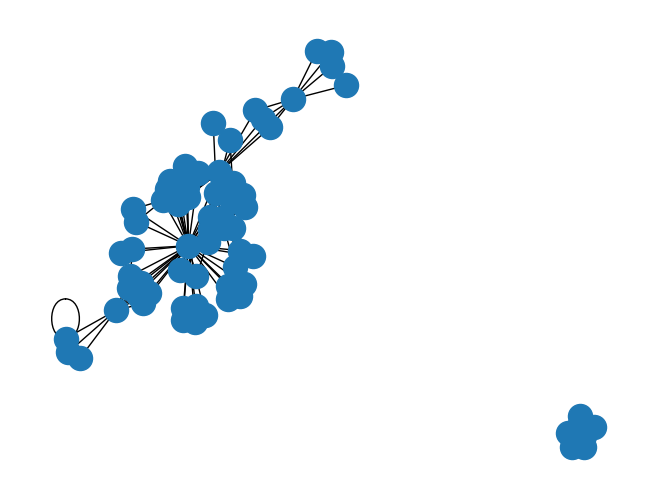

In [14]:
import networkx as nx
import pickle
from itertools import combinations

unweighted_g = nx.Graph()

lists_of_people = pickle.load(open('lists_of_people.pkl', 'rb'))

print(lists_of_people)

for l in lists_of_people:
    e = combinations(l, r=2)
    unweighted_g.add_edges_from(e)

pos = nx.spring_layout(unweighted_g)
nx.draw(unweighted_g, pos=pos)
    

# Your turn: build a graph that links people mentioned in the same article!

### What can we do with our network?
Let's think about what we can learn from our network. One way to figure out who the important players in a particular network is called *k-core decomposition*. In plain terms, obtaining the [*k-core*](https://www.baeldung.com/cs/graph-k-core) of a graph for a particular value of *k* means we look at all the nodes in our network. If their degree is greater than or equal to *k*, we keep them. Otherwise, we remove them. 

### Interactive Moment
What do you think the k-core of the TMZ mention network made of articles about the Kardashian/Jenner family will tell us about the Kardashain/Jenner family?

### K-core size
First, let's plot the size of the k-core of this network as *k* increases.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
n_in_k_core = []
for k in range(1, 10):
    n_in_k_core.append(len(nx.k_core(unweighted_g, k)))
plt.plot([k for k in range(1, 10)], n_in_k_core)
plt.xlabel('Value of k')
plt.ylabel('Number of individuals in k-core')
plt.title('K-core size of Kardashian/Jenner TMZ Mention Network')

### Fun Activity
How would you answer these questions, using your TMZ mention network and k-core decomposition?
* Who is most important to the Kardashian/Jenner family? 
* Who is least important? 

In [10]:
# Your Turn!

### Another Fun Activity
Try to figure out the following exercises:
* Can you figure out who are the highest-degree nodes in your network? Are there any that are surprising?
* Compare your results with the results from the scraping run you did in your `screen` session. What's similar? What's different?

In [11]:
# Your Turn!

## Weighted k-core decomposition
The networks we just created and ran k-core decomposition algorithms on were unweighted, as is typical for k-core decomposition. We're going to construct a weighted graph and then use the weighted k-core definition from [this paper](http://www.graphdegeneracy.org/k-cores.pdf) to run a weighted k-core decomposition. 

First, let's write a function that takes a list of article URLs as input and constructs a *weighted* graph. Each edge between nodes $(i, j)$ should be weighted according to the number of times $i$ and $j$ appeared together in the same article.

In [13]:
# Your Turn!
def make_weighted_graph_from_urls(url_list):
    """
    Given a list of valid TMZ article URLs, constructs a weighted networkx graph object.
    Each edge between person i and person j is weighted 
    according to the number of times i and j appeared in the same article.
    """
    pass

Next, write a function that does the weighted k-core decomposition specified in the article linked above. You may find the `networkx` [subgraph view](https://networkx.org/documentation/stable/reference/classes/generated/networkx.classes.graphviews.subgraph_view.html) function helpful here.

In [14]:
# Your Turn!
def weighted_kcore_decomposition(nx_graph, k):
    """
    Given a networkx weighted graph object, 
    compute the weighted k-core decomposition for the given value of k.
    """
    pass


After that, write code to plot the number of nodes remaining in each weighted k-core over a range of reasonable values. 

In [ ]:
# Your Turn!
%matplotlib inline
import matplotlib.pyplot as plt

network_sizes = []
for k in range(0, 100): # TODO: change upper limit as needed
    weighted_kcore = weighted_kcore_decomposition(my_graph, k)
    network_size = 0 # TODO: get the size of the network
    network_sizes.append(network_size)
    
plt.title('Size of weighted k-core')
plt.xlabel('Value of k')
plt.ylabel('Nodes in weighted k-core')
plt.plot([k for k in range(0, 100)], network_sizes)

Finally, compare the k-core decomposition results from the unweighted network to the weighted network. How are they similar? How are they different?

In [ ]:
# Your Turn!

## Resources

[Are the Kardashians Losing Their Influence?](https://www.elle.com/uk/life-and-culture/culture/a46440253/the-kardashians-influence/) (this is not serious reading sorry)

[MediaCloud](https://www.mediacloud.org/) is worth a second look; it's a great source for looking at news across the US and across the world. If you're studying news coverage at all, I would highly recommend checking it out!

[More on Linux Screen](https://linuxhandbook.com/screen-command/)

[More on logging in Python](https://realpython.com/python-logging/)

[An explanation of a graph's k-core](https://www.baeldung.com/cs/graph-k-core)

[Giatsidis et al. on weighted k-core decomposition](http://www.graphdegeneracy.org/k-cores.pdf)